In [131]:
import numpy as np
import pandas as pd
import cftime
import re
import os
import matplotlib.pyplot as plt

In [146]:
variable = "tasmax"
variable_ba = variable+"_ba"
variable_period = "day"
ssp = "ssp585"
data_folder = "./data/csv/models/"+variable+"_"+variable_period+"/CMIP6/"+ssp+"/predictions/unbiased"
years = np.arange(2023,2071)

models_data = dict()
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        model = re.search(variable_period+'_(.+?)_ssp', filename).group(1)
        models_data[model] = dict()
        models_data[model]["data"] = pd.read_csv(data_folder+"/"+filename, index_col=0)

In [147]:
winter = "dec-jan-feb"
spring = "mar-apr-may"
summer = "jun-jul-aug"
autumn = "sep-oct-nov"
months_periods = {
    winter:[12, 1, 2],
    spring:[3, 4, 5],
    summer:[6, 7, 8],
    autumn:[9, 10, 11]
}

In [148]:
for model, model_values in models_data.items():
    data = model_values["data"]
    # Ajout de la saison et de l'année
    data["season"] = data.index.map(lambda x: [period for period, month in months_periods.items()
                                               if int(x.split("-")[1]) in month][0])
    data["year"] = data.index.map(lambda x: int(x.split("-")[0]))

In [152]:
tas_threshold = {
    winter: 15,
    spring: 25,
    summer: 35,
    autumn: 25
}

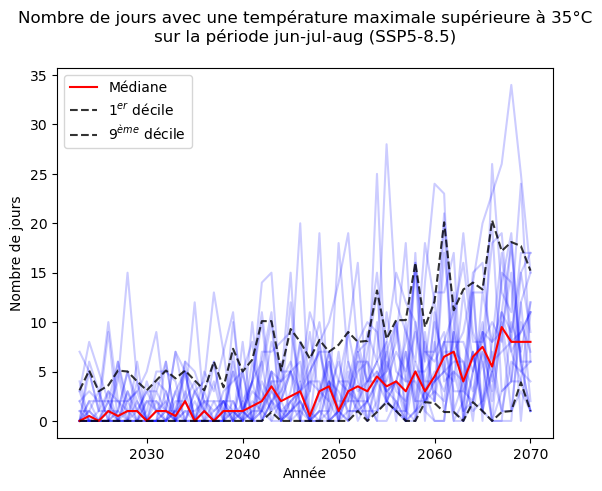

In [153]:
period = summer
nb_days_over_threshold = {}

for model, model_values in models_data.items():
    data = model_values["data"]
    period_data = data[data["season"] == period].groupby("year")
    nb_days_over_threshold[model] = list(period_data.apply(lambda x: len(x[x[variable_ba] > tas_threshold[period]])))

    plt.plot(years, nb_days_over_threshold[model], "-b", alpha=0.2)

# On calcul la médiane année par année
median = np.median([nb_days_over_threshold[model] for model in models_data.keys()], axis=0)
plt.plot(years, median, "-r", label="Médiane")

# On calcule le 1er et 9ème décile année par année
deciles = np.percentile([nb_days_over_threshold[model] for model in models_data.keys()], [10, 90], axis=0)
plt.plot(years, deciles[0], "--k", label="$1^{er}$ décile", alpha=0.8)
plt.plot(years, deciles[1], "--k", label="$9^{ème}$ décile", alpha=0.8)

plt.legend()
plt.xlabel("Année")
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours avec une température maximale supérieure à "+str(tas_threshold[period])+"°C\nsur la période "+period+" (SSP5-8.5)", y=1.05)

plt.savefig(f"nbdays-thresholds-{tas_threshold[period]}tasmax_{period}_{ssp}.png", bbox_inches="tight")
plt.show()

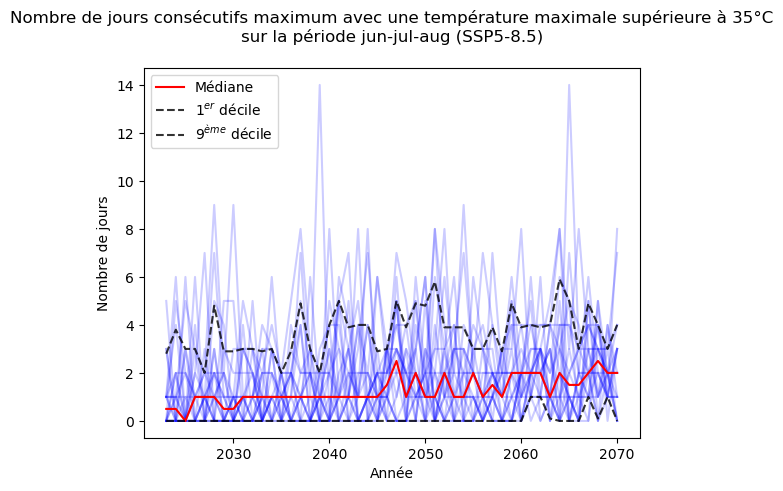

In [137]:
nb_consecutive_days_over_threshold = {}

for model, model_values in models_data.items():
    data = model_values["data"]
    data["above_threshold"] = data[variable_ba] > tas_threshold[period]
    data["longest_period"] = 0
    # Itérer sur les lignes
    current = 0
    for time, row in data[data["season"] == period].iterrows():
        if row["above_threshold"]:
            current += 1
        else:
            current = 0
        data.at[time, "longest_period"] = current
    period_data = data[data["season"] == period].groupby("year")
    nb_consecutive_days_over_threshold[model] = list(period_data.apply(lambda x: max(x["longest_period"])))
    plt.plot(years, nb_consecutive_days_over_threshold[model], "-b", alpha=0.2)

# On calcul la médiane année par année
median = np.median([nb_consecutive_days_over_threshold[model] for model in models_data.keys()], axis=0)
plt.plot(years, median, "-r", label="Médiane")

# On calcule le 1er et 9ème décile année par année
deciles = np.percentile([nb_consecutive_days_over_threshold[model] for model in models_data.keys()], [10, 90], axis=0)
plt.plot(years, deciles[0], "--k", label="$1^{er}$ décile", alpha=0.8)
plt.plot(years, deciles[1], "--k", label="$9^{ème}$ décile", alpha=0.8)

plt.legend()
plt.xlabel("Année")
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours consécutifs maximum avec une température maximale supérieure à "+str(tas_threshold[period])+"°C\nsur la période "+period+" (SSP5-8.5)", y=1.05)

plt.show()
    